# Tutorial: Forecasting Dengue Incidence in Brazil with Python and Machine Learning Models

This notebook provides step-by-step instructions to complete the tutorial 'Forecasting Dengue Incidence in Brazil with Python and Machine Learning Models'. By the end of this tutorial, you should be comfortable loading and cleaning data, training your model, visualising and evaluating the outputs, and making small adjustments to the model structure.

## Anticipated Learning Outcomes
1. Design and evaluate forecasting models for infectious diseases
2. Implement the Python library 'DARTS' for performing time-series forecasting
3. Understand how to integrate covariate data into forecasting models of infectious disease

---

**Google Colab**: We are using Colab for this tutorial, instructions to mount your Drive and configure your data filepath are below (see next cell).

## Colab setup: Mount Drive and set data path


1. Create a folder in your drive called `forecasting_tutorial` where you will later upload the data files for the practical
2. Run the cell below to mount Google Drive.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Path to the folder containing: EPI CSV, NetCDF files (reanalysis, spe06, population, seasonal forecast).
DATA_DIR = '/content/drive/MyDrive/forecasting_tutorial'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*Note that the folder you create in your drive can have any name, provided the filepath that `DATA_DIR` points to is updated accordingly to reflect the correct name and destination of the folder*

## Load necessary packages
Before we get started we will load the `darts` package, which contains a suite of useful functions and models for time series forecasting. We encourage you to [consult the `darts` documentation](https://unit8co.github.io/darts/) to learn more about the different model types and how they are implemented.

In [2]:
# Install darts
!pip install -q darts

---

# 1. Data: Cleaning, understanding and preparing

## 1.1 Obtaining the data from Global.health

First, we will obtain the data we will use in this practical from the [Global.health data repository](https://sim-dev-data.covid-19.global.health/data-downloads). For this you will need to sign in with your google account and be granted access by an admin.

Our country of interest is Brazil, and the Brazil data files are housed on the repo with the prefix 'BRA':


*   **`BRA_epi_training.csv`**
*   `BRA-ccvi.zs.nc`
*   `BRA-gdp_pc.zs.nc`
*   `BRA_population.zs.nc`
*   `BRA-reanalysis_monthly.zs.nc`
*   `BRA-seasonal_forecast_monthly.zs.nc`
*   `BRA_spa01.zs.nc`
*   `BRA-spa03.zs.nc`
*   `BRA-spa06.zs.nc`
*   `BRA_spa12.zs.nc`
*   `BRA_spe01.zs.nc`
*   `BRA-spe03.zs.nc`
*   `BRA-spe06.zs.nc`
*   `BRA_spe12.zs.nc`
*   `BRA-surv_wmean.zs.nc`
*   `BRA-svwl1.zs.nc`
*   `BRA_w_piped.zs.nc`

While at first, we will run a univariate model that predicts cases without using any of these predictor datasets, during data prep we will get the full data ready. Accordingly, you should download each of these datasets and place them in the directory on your google drive indicated by `DATA_DIR` (unless you have chosen a different name, this is probably `forecasting_tutorial`).

### Descriptions of the data
More information on each of the datasets are available on [the tutorial github](https://github.com/kraemer-lab/Dengue_Forecasting_Tutorial/tree/main/data). We encourage you to read this information to familiarise yourself with what data is available, which will be particularly helpful later in the tutorial and for your assignment.


## 1.2 Full data integration

We merge the epidemiological target (dengue cases) which is stored in `BRA_epi_training.csv` with historical covariates and seasonal forecasts from NetCDF files. The result is a single table with cases, log(cases+1), and covariates per region and month.

In [3]:
import os
import pandas as pd
import numpy as np
import xarray as xr

def to_month_end(date_series):
    """Align dates to the last day of the month."""
    return pd.to_datetime(date_series) + pd.offsets.MonthEnd(0)

# --- Paths (all under DATA_DIR) ---
epi_file = os.path.join(DATA_DIR, 'BRA_epi_training.csv')
fc_file = os.path.join(DATA_DIR, 'BRA-seasonal_forecast_monthly.zs.nc')
hist_files = {
    os.path.join(DATA_DIR, 'BRA-reanalysis_monthly.zs.nc'): None,
    os.path.join(DATA_DIR, 'BRA-spe06.zs.nc'): None,
    os.path.join(DATA_DIR, 'BRA-population.zs.nc'): {'population': 'pop_count'}
}

# 1. Load target data (EPI)
df_epi = pd.read_csv(epi_file)
df_epi['Region'] = df_epi['Region'].astype(int)
df_epi['Date'] = to_month_end(df_epi['Month'])
df_epi = df_epi.drop(columns=['Month', 'Unnamed: 0'], errors='ignore')
if df_epi.duplicated(subset=['Region', 'Date']).any():
    df_epi = df_epi.groupby(['Region', 'Date']).mean(numeric_only=True).reset_index()

df_final = df_epi.copy()

# 2. Historical covariates (standard merge)
print("Merging historical covariates...")
for f, rename_map in hist_files.items():
    if not os.path.exists(f):
        continue
    ds = xr.open_dataset(f)
    df_nc = ds.to_dataframe().reset_index()
    ds.close()
    df_nc.rename(columns=lambda x: x.lower() if x in ['time', 'region'] else x, inplace=True)
    df_nc.rename(columns={'time': 'Date', 'region': 'Region'}, inplace=True)
    df_nc['Region'] = pd.to_numeric(df_nc['Region'], errors='coerce')
    df_nc.dropna(subset=['Region'], inplace=True)
    df_nc['Region'] = df_nc['Region'].astype(int)
    df_nc['Date'] = to_month_end(df_nc['Date'])
    cols_drop = [c for c in df_nc.columns if c in ['spatial_ref', 'crs', 'bnds', 'month_number']]
    df_nc.drop(columns=cols_drop, inplace=True, errors='ignore')
    if rename_map:
        df_nc.rename(columns=rename_map, inplace=True)
    if df_nc.duplicated(subset=['Region', 'Date']).any():
        df_nc = df_nc.groupby(['Region', 'Date']).mean(numeric_only=True).reset_index()
    df_final = pd.merge(df_final, df_nc, on=['Region', 'Date'], how='left')

# 3. Seasonal forecast cube (flatten leads 1..6 into columns)
fc_cols = []
if os.path.exists(fc_file):
    print("Processing seasonal forecast cube...")
    ds = xr.open_dataset(fc_file)
    df_fc = ds.to_dataframe().reset_index()
    ds.close()
    df_fc.rename(columns=lambda x: x.lower() if x in ['time', 'region', 'month'] else x, inplace=True)
    df_fc.rename(columns={'time': 'Date', 'region': 'Region'}, inplace=True)
    df_fc['Region'] = pd.to_numeric(df_fc['Region'], errors='coerce')
    df_fc.dropna(subset=['Region'], inplace=True)
    df_fc['Region'] = df_fc['Region'].astype(int)
    df_fc['Date'] = to_month_end(df_fc['Date'])
    value_vars = [c for c in df_fc.columns if c not in ['Region', 'Date', 'month', 'spatial_ref', 'crs']]
    df_pivoted = df_fc.pivot_table(index=['Region', 'Date'], columns='month', values=value_vars)
    df_pivoted.columns = [f"{col}_L{lead}" for col, lead in df_pivoted.columns]
    df_pivoted = df_pivoted.reset_index()
    df_final = pd.merge(df_final, df_pivoted, on=['Region', 'Date'], how='left')
    fc_cols = [c for c in df_pivoted.columns if c not in ['Region', 'Date']]
    print(f"  Added {len(fc_cols)} forecast features.")
else:
    print("Seasonal forecast file not found; skipping.")

# Interpolate / forward-fill where needed
df_final.sort_values(['Region', 'Date'], inplace=True)
if 'pop_count' in df_final.columns:
    df_final['pop_count'] = df_final.groupby('Region')['pop_count'].transform(lambda x: x.interpolate(limit_direction='both'))
if fc_cols:
    df_final[fc_cols] = df_final.groupby('Region')[fc_cols].transform(lambda x: x.ffill())

# Target for modelling: log(cases + 1)
df_final['LogCases'] = np.log1p(df_final['Cases'])

df_final.sort_values(by=['Region', 'Date'], inplace=True)
outfile = os.path.join(DATA_DIR, 'BRA_integrated_forecasting_data.csv')
df_final.to_csv(outfile, index=False)
print(f"Saved to {outfile}")
print("Columns:", df_final.columns.tolist())

Merging historical covariates...
Processing seasonal forecast cube...
  Added 30 forecast features.
Saved to /content/drive/MyDrive/forecasting_tutorial/BRA_integrated_forecasting_data.csv
Columns: ['Country', 'Region', 'Cases', 'Spatial_Resolution', 'Date', 't2m', 'rh', 'tp', 'spe06', 'pop_count', 'area', 'pop_density', 'mn2t24_L1.0', 'mn2t24_L2.0', 'mn2t24_L3.0', 'mn2t24_L4.0', 'mn2t24_L5.0', 'mn2t24_L6.0', 'mx2t24_L1.0', 'mx2t24_L2.0', 'mx2t24_L3.0', 'mx2t24_L4.0', 'mx2t24_L5.0', 'mx2t24_L6.0', 'rh_L1.0', 'rh_L2.0', 'rh_L3.0', 'rh_L4.0', 'rh_L5.0', 'rh_L6.0', 't2m_L1.0', 't2m_L2.0', 't2m_L3.0', 't2m_L4.0', 't2m_L5.0', 't2m_L6.0', 'tp_L1.0', 'tp_L2.0', 'tp_L3.0', 'tp_L4.0', 'tp_L5.0', 'tp_L6.0', 'LogCases']


After running this chunk, a number of new data frames will be available in the data inspector. These include:



*   `df_epi`: a data frame of epi cases by region (municipality) in Brazil
*   `df_fc`: a data frame consisting of seasonal forecasts flattened into columns (and `df_pivoted`, a pivoted version of this used as an intermediate step)
*   `df_nc`: a data frame of historical covariates
*   `df_final`: a data frame we can use for the rest of the tutorial which has, for each date, the forecast target (log transformed cases) and covariate values.







> ***THEORY BREAK: HISTORICAL VS FORECASTED COVARIATES - WHAT'S THE DIFFERENCE??***
>
> *When forecasting dengue, it’s important to distinguish between historically observed predictor data and forecasted predictor data. For a date like June 1, 2015, the observed temperature is the value that was actually measured on that day. In contrast, forecasted temperatures are predictions made ahead of time — for example, what temperature was predicted on April 1 or May 1 for June 1. These values differ because forecasts are made with incomplete information and uncertainty, so they may not match what ultimately occurred. When building models retrospectively, using observed covariates can show how well a model could perform with perfect knowledge of the future. However, in real-time forecasting, we sometimes must use the forecasted covariates that would have been available at the time to avoid using information from the future. This setup also highlights the three-dimensional nature of forecasts: each value depends not only on the date being predicted, but also on when the forecast was issued. As a result, the same calendar date can have multiple forecasted values, one from each prior forecast date - this is why we had to 'flatten' the seasonal forecast dataset.*


## 1.3 Filter to Rio de Janeiro and explore

Our processed data has multiple concurrent time series for every municipality in Brazil (more than 5,000!). While the most thorough forecasting models will forecast for all of these locations together (and may also use information from different municipalities to 'help' each other), for now we will keep it simple and focus on a single time series. For this first section, we are going to focus on the **municipality of Rio de Janeiro**, identified by `Region == 3304557`.

In [4]:
RIO_REGION = 3304557  # Municipality of Rio de Janeiro

df_rio = df_final[df_final['Region'] == RIO_REGION].sort_values('Date').copy()
df_rio = df_rio.dropna(subset=['LogCases'])

print(f"Rio de Janeiro (Region {RIO_REGION}): {len(df_rio)} months")
print(f"Date range: {df_rio['Date'].min()} to {df_rio['Date'].max()}")
df_rio[['Date', 'Cases', 'LogCases']].head(10)

Rio de Janeiro (Region 3304557): 107 months
Date range: 2014-12-31 00:00:00 to 2023-10-31 00:00:00


,Date,Cases,LogCases
346363,2014-12-31,30,3.433987
346364,2015-01-31,220,5.398163
346365,2015-02-28,353,5.869297
346366,2015-03-31,1478,7.299121
346367,2015-04-30,4441,8.398860
346368,2015-05-31,5861,8.676246
346369,2015-06-30,3216,8.076205
346370,2015-07-31,1387,7.235619
346371,2015-08-31,1098,7.002156
346372,2015-09-30,517,6.249975


To help us to understand the data, we will use `matplotlib` to generate a plot of cases and log-transformed cases.

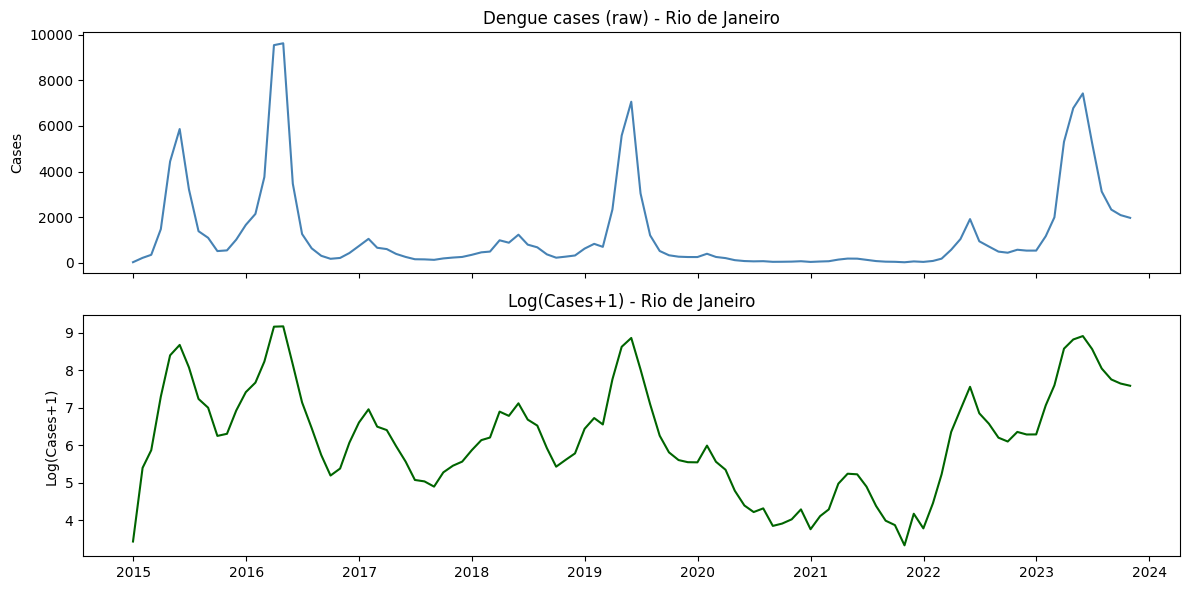

In [5]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax1.plot(df_rio['Date'], df_rio['Cases'], color='steelblue')
ax1.set_ylabel('Cases')
ax1.set_title('Dengue cases (raw) - Rio de Janeiro')
ax2.plot(df_rio['Date'], df_rio['LogCases'], color='darkgreen')
ax2.set_ylabel('Log(Cases+1)')
ax2.set_title('Log(Cases+1) - Rio de Janeiro')
plt.tight_layout()
plt.show()

---

# 2. Model: Temporal Convolutional Network Model (6‑month horizon, no covariates)

Now that we have our data cleaned, processed, and ready to go, it's time to build our first forecasting model! We will focus on the data we have subset from Rio de Janeiro for now, and build a forecasting model using **cases only - no covariates**.

We will use the `darts` python library, which specialises in time series manipulation and forecasting. We'll fit a **TCN (Temporal Convolutional Network)** model.

### About TCN Models
TCN models model time series objects by using convolutions over time to learn patterns in past data. The model looks back at a window of past values (the 'signal'), e.g. the last 10 months of dengue cases and detects patterns such as trends or seasonality, which it can use to produce a forecast.

### TCNs in practice
In practice, using TCNs you can specify many different parameters that we will explore today, some of which include:
*   `input_chunk_length`: how big the 'window of past values' should be (also can be called 'context window')
*   `output_chunk_length`: how far ahead the model should predict (also can be called 'forecast horizon'.
*   `kernel_size`: the width of the convolutional filter. A kernel size of 3 means each convolution looks at 3 adjacent time steps at a time when extracting patterns.
*   `num_filters`: the number of convolutional filters in each layer. More filters allow the model to learn more distinct temporal features, but increase model complexity.
*   `dropout`: this helps prevent overfitting by randomly “turning off” some proportion of neurons during training.
*   `likelihood`: controls whether forecasts are deterministic (i.e. only generating a single point prediction) or probablistic (i.e. predict a range of plausible futures)


## Load packages and dependencies

In [8]:
!pip install -q pytorch_lightning

import torch
import uuid
from darts import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.missing_values import fill_missing_values
from darts.dataprocessing.transformers import Scaler
from darts.models import TCNModel
from darts.utils.likelihood_models import QuantileRegression

HORIZON = 6
INPUT_CHUNK_LENGTH = 24
OUTPUT_CHUNK_LENGTH = 6
NUM_SAMPLES = 500  # for probabilistic forecasts (CRPS, WIS)

In the above code chunk we install and load the necessary packages, and specify some parameters. The forecast horizon (and thus, output chunk length) is set to 6 months, the input chunk length is set to 24 months, and the number of samples (i.e. number of 'guesses' the forecast model should take is set to 500.

**The idea of taking multiple samples is a very important part of forecasting** - A single point forecast hides the uncertainty inherent in predicting complex systems like dengue transmission. Generating multiple forecast samples allows us to represent the full range of plausible futures and quantify uncertainty through prediction intervals. These forecast windows are more informative for decision-making and enable proper evaluation of probabilistic accuracy, rather than relying only on point-error metrics.

## Divide data into training and testing sets

Next we will format our data into time series objects, and divide it into our training and testing sets by providing a `split_date` - all data before this date will be used to train the model, and data after this date can be used for testing.. The training sets will be used to (you guessed it) train the model, and the testing set will be used to evaluate the model performance. It's important that you separate the data into these folds to prevent leakage, i.e., the model accidentally 'seeing' and learning from future data, which will then bias the results when you test on that data.

In [9]:
# Build univariate time series (log scale)
ts_target = TimeSeries.from_dataframe(
    df_rio, time_col='Date', value_cols='LogCases', freq='ME'
)
ts_target = fill_missing_values(ts_target)

# Train / test split (you can change the split or use your own holdout)
# Example: train up to mid 2022, test from mid 2022 onwards
split_date = pd.Timestamp('2022-06-30')
train_target = ts_target.drop_after(split_date)
test_target = ts_target.drop_before(split_date)

print(f"Train: {train_target.start_time()} to {train_target.end_time()} ({len(train_target)} points)")
print(f"Test:  {test_target.start_time()} to {test_target.end_time()} ({len(test_target)} points)")

Train: 2014-12-31 00:00:00 to 2022-05-31 00:00:00 (90 points)
Test:  2022-07-31 00:00:00 to 2023-10-31 00:00:00 (16 points)


## Define and fit our model
Next we will train the TCN model on our training data. First we specify the `model` structure using `TCNModel()`, then train the model using `model.fit()`.

In [11]:
# Scale the target for training (fit on train only)
scaler = Scaler()
train_scaled = scaler.fit_transform(train_target)

model = TCNModel(
    input_chunk_length=INPUT_CHUNK_LENGTH,  # Look back 24 months
    output_chunk_length=OUTPUT_CHUNK_LENGTH,  # Forecast 6 months
    kernel_size=3,
    num_filters=32,
    dilation_base=2,
    dropout=0.1,
    likelihood=QuantileRegression(), # <--- Generates probabilistic samples
    random_state=42,
    model_name="TCN_univariate",
    force_reset=True,
    save_checkpoints=False,
    pl_trainer_kwargs={"accelerator": "cpu"}
)

model.fit(series = train_scaled, verbose=False)
print("TCN fit complete.")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


TCN fit complete.


## Predict from the trained model
Now we will use our trained forecasting model to make a prediction. We will sample many predictions from our model (`NUM_SAMPLES`) and summarise these using quantiles. This will generate another data frame in the Data inspector called `df_forecast`, which holds our predictions.

In [12]:
# Predict 6 months ahead
pred_scaled = model.predict(
    n=HORIZON,
    series=train_target,
    num_samples=NUM_SAMPLES
)

# Inverse Transform (Scales back the values, keeps the samples structure)
pred_log = scaler.inverse_transform(pred_scaled)

print(f"Prediction Shape: {pred_log.values().shape} (Time, Components, Samples)")

# Compute Quantiles and Store in Data Frame
QUANTILES = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
results = {'Date': pred_log.time_index}

for q in QUANTILES:
    # .quantile(q) reduces the samples to a single value per time step
    q_series = pred_log.quantile(q)
    results[f"q{q:.2f}"] = q_series.values().flatten()

df_forecast = pd.DataFrame(results).set_index('Date')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


Output()

Prediction Shape: (6, 1) (Time, Components, Samples)


---

# 3. Visualisation and evaluation

When we wish to explore how well our forecasts align with what is actually observed, we can plot them visually in addition to calculating performance metrics. Here, we will do both.

## 3.1 Visualising your predictions

To visualise out predictions, we will plot them alongside some of the held out testing data:

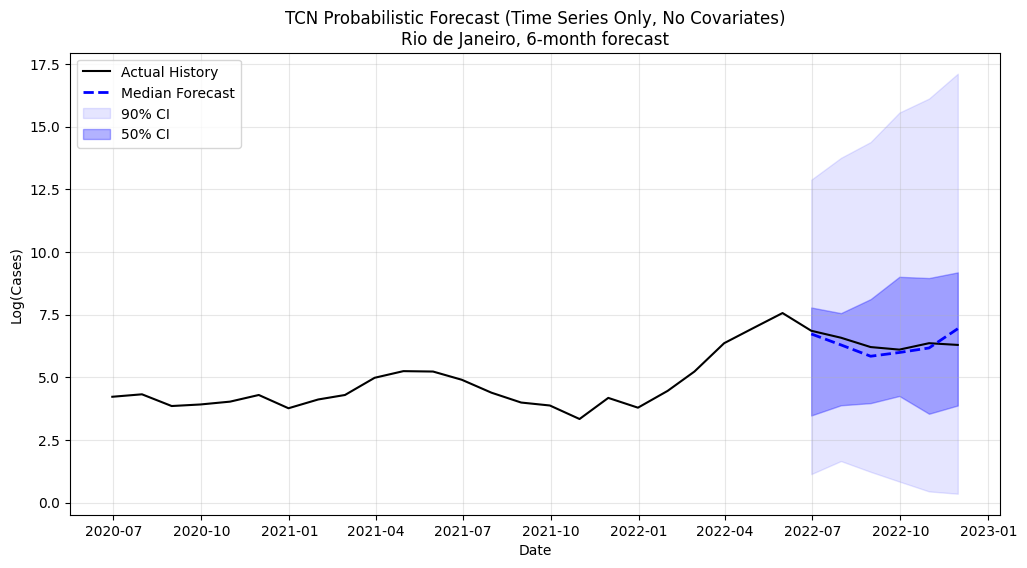

In [13]:
# Get Ground Truth for the forecast period + some history
full_actual = ts_target.slice(split_date - pd.DateOffset(months=INPUT_CHUNK_LENGTH), split_date + pd.DateOffset(months=HORIZON))
df_actual = pd.DataFrame({
    'Actual': full_actual.values().flatten()
}, index=full_actual.time_index)

# Merge for perfect alignment on the plot
df_plot = df_actual.join(df_forecast, how='outer')

plt.figure(figsize=(12, 6))

# Plot History (Black)
plt.plot(df_plot.index, df_plot['Actual'], color='black', label='Actual History', linewidth=1.5)

# Plot Forecast (Blue)
# We filter to where we actually have forecasts
subset = df_plot.dropna(subset=['q0.50'])

plt.plot(subset.index, subset['q0.50'], color='blue', label='Median Forecast', linewidth=2, linestyle='--')

# Fan Chart
plt.fill_between(subset.index, subset['q0.05'], subset['q0.95'], color='blue', alpha=0.1, label='90% CI')
plt.fill_between(subset.index, subset['q0.25'], subset['q0.75'], color='blue', alpha=0.3, label='50% CI')

plt.title(f"TCN Probabilistic Forecast (Time Series Only, No Covariates)\nRio de Janeiro, 6-month forecast")
plt.xlabel("Date")
plt.ylabel("Log(Cases)")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()


## 3.2 Why scoring rules? Calibration and sharpness
When we have probabilistic forecasts (e.g. many samples or quantiles), we care about:

*   **Calibration**: Do prediction intervals contain the true value the stated proportion of the time? (e.g. 90% intervals should contain the observation about 90% of the time.)
*   **Sharpness**: How narrow are the intervals? We prefer narrower intervals when they are well calibrated.

A proper scoring rule is a single number that summarises how well the forecast distribution matches the data-generating process, or the true distribution. These can be used to express calibration and sharpness. Using a proper score avoids incentives to report overconfident or underconfident forecasts.

Here we will look at three metrics:

*   **RMSE (root mean squared error):** For point forecasts (e.g. median). Lower is better. It does not assess calibration or full distribution and thus does not evaluate the full predictive distribution.
*   **CRPS (Continuous Ranked Probability Score):** For probabilistic forecasts that generate a distribution of samples. It evaluates the entire predictive distribution by measuring how close the forecast cumulative distribution is to the observed outcome. Lower is better.
*   **WIS (Weighted Interval Score):** For quantile (or interval) forecasts. It combines interval width and penalties when the observation falls outside the interval. Lower is better. It approximates CRPS and is a proper scoring rule for quantile forecasts.


Other metrics you might report: MAE, coverage of central intervals (e.g. 50%, 90%), mean interval width

## 3.3 RMSE (point forecast)

Next we will calculate RMSE of the median forecast vs actual cases. RMSE (Root Mean Squared Error) is a commonly used metric to evaluate the accuracy of point forecasts. It measures the average magnitude of the errors between predicted values and observed values. Here's how to interpret it:

*   **Magnitude of Error**: RMSE provides a single, aggregate measure of prediction error. The value of RMSE is in the same units as the predicted variable (in our case, `LogCases` or `Cases` if transformed back).
*   **Lower is Better**: A lower RMSE value indicates a better fit of the model to the data. This means the predictions are closer to the actual observations.
*   **Sensitivity to Large Errors**: Because errors are squared before they are averaged, RMSE gives a relatively high weight to large errors. This means it's particularly useful when large errors are undesirable and should be penalized more heavily than smaller errors.
*   **Comparison**: RMSE is most useful when comparing different models or different configurations of the same model. For instance, if Model A has an RMSE of 1.5 and Model B has an RMSE of 0.8, Model B is generally considered more accurate.
*   **Context is Key**: While a lower RMSE is always better, what constitutes a 'good' RMSE value is highly dependent on the context and the scale of the data. For example, an RMSE of 1.0 might be excellent for predicting a variable that ranges from 0 to 1000, but poor for a variable that ranges from 0 to 10.

In [14]:
from darts.metrics import rmse

# Get the median prediction from the probabilistic forecast (log scale)
pred_median_log = pred_log.quantile(0.5)

# On log scale (common for modelling)
rmse_log = rmse(test_target[:HORIZON], pred_median_log)
print(f"RMSE (log scale): {rmse_log:.4f}")

RMSE (log scale): 0.3695


## 3.4 CRPS (Continuous Ranked Probability Score)

CRPS is a *proper scoring rule* for probabilistic forecasts, meaning it provides a fair and comprehensive evaluation of an entire forecast distribution (not just a single point prediction). It measures the difference between the forecast cumulative distribution function (CDF) and the empirical CDF of the observed outcome. Here's a breakdown of its interpretation:

*   **Evaluates the Full Distribution**: Unlike metrics such as RMSE or MAE that only assess point forecasts, CRPS considers the entire predicted probability distribution. This means it rewards forecasts that are both accurate (their central tendency is close to the observed value) and sharp (their uncertainty is narrow).
*   **Units**: CRPS is in the same units as the observed variable (in our case, `LogCases`). This makes it intuitively understandable; a CRPS of 1.0 means, on average, the probabilistic forecast is "off" by about 1 unit on the log scale.
*   **Lower is Better**: A lower CRPS value indicates a better forecast. A perfect deterministic forecast (where the predicted value equals the observed value) would have a CRPS of zero.
*   **Relationship to MAE**: For deterministic forecasts (a single point prediction), CRPS simplifies to the Mean Absolute Error (MAE). For probabilistic forecasts, it can be thought of as a generalization of MAE that accounts for the entire distribution.
*   **Robustness**: CRPS is less sensitive to outliers than squared-error metrics like RMSE, as it uses absolute differences rather than squared differences in its underlying calculation. This makes it a robust measure for evaluating forecast accuracy in many contexts.
*   **Comparison**: CRPS is particularly useful for comparing different probabilistic forecasting models. A model yielding a lower CRPS is generally considered superior, as its forecast distributions are, on average, closer to the true data-generating process.

For an ensemble of samples, we use the mean CRPS over time steps. We compute it on the **log scale** (where the model is defined); you can also report it on the cases scale if you convert samples accordingly.

In [16]:
# CRPS from ensemble samples (log scale)
!pip install -q properscoring
try:
    import properscoring as ps
    HAS_PS = True
except ImportError:
    HAS_PS = False

if HAS_PS:
    # pred_log has shape (samples, time, 1)
    samples = pred_log.all_values()  # (n_timesteps, n_components, n_samples)
    # For univariate: (n_timesteps, 1, n_samples) -> (n_timesteps, n_samples)
    forecast_ensemble = np.moveaxis(samples, -1, 0)  # (n_samples, n_timesteps, 1)
    obs = test_target[:HORIZON].values().flatten()
    crps_vals = []
    for t in range(min(HORIZON, len(obs))):
        crps_t = ps.crps_ensemble(obs[t], forecast_ensemble[:, t, 0])
        crps_vals.append(crps_t)
    crps_mean = np.mean(crps_vals)
    print(f"CRPS (log scale, mean over horizon): {crps_mean:.4f}")
else:
    print("Install properscoring for CRPS: pip install properscoring")

CRPS (log scale, mean over horizon): 0.8476


## 3.5 WIS (Weighted Interval Score)

WIS is defined from symmetric quantile pairs and the median, and is a comprehensive proper scoring rule specifically designed for evaluating *quantile forecasts* or *interval forecasts*. For each pair (e.g. 0.05 and 0.95), we compute the interval score (width + penalties if the observation is outside). WIS is a weighted average of these plus the median absolute error. Lower is better.

*   **Proper Scoring Rule**: Like CRPS, WIS is a proper scoring rule. This means it provides an unbiased and comprehensive evaluation of the forecast, encouraging forecasters to state their true beliefs about the future.
*   **Combines Sharpness and Calibration**: WIS considers both the width of the prediction intervals (sharpness) and whether the actual observation falls within those intervals (calibration). It penalizes wide intervals and also penalizes instances where the observation falls outside the predicted intervals.
*   **Weighted Average of Interval Scores**: WIS is calculated as a weighted average of scores for various prediction intervals (e.g., 50%, 90%). For each interval, a score is computed based on its width and penalties if the observed value falls outside its bounds. The median forecast also contributes to the score (similar to MAE).
*   **Lower is Better**: A lower WIS value indicates a superior forecast. This means the forecast is both sharp (narrow prediction intervals) and well-calibrated (the true values fall within the intervals at the expected frequency).
*   **Approximation of CRPS**: WIS can be seen as an approximation of CRPS, especially when using a sufficient number of quantile levels. For practical purposes, it's often preferred for quantile forecasts because it directly leverages the quantile structure.
*   **Units**: Similar to CRPS and RMSE, WIS is in the same units as the observed variable (e.g., `LogCases`). This provides an intuitive understanding of the average "error" of the probabilistic forecast.

In [17]:
def wis_from_quantiles(actual, q_dict):
    """
    WIS for one observation given quantile predictions.
    q_dict: e.g. {0.05: val, 0.5: median, 0.95: val, ...}
    """
    if np.isnan(actual):
        return np.nan
    qs = sorted(q_dict.keys())
    K = len(qs) // 2
    median = q_dict.get(0.5)
    if median is None:
        median = q_dict[qs[len(qs)//2]]
    wis_sum = 0.5 * np.abs(actual - median)
    for k in range(K):
        alpha = 2 * qs[k]
        L = q_dict[qs[k]]
        U = q_dict[qs[-(k+1)]]
        score = (U - L)
        if actual < L:
            score += (2 / alpha) * (L - actual)
        if actual > U:
            score += (2 / alpha) * (actual - U)
        wis_sum += score
    return wis_sum / (K + 0.5)

# Build quantile dict per time step (log scale)
quantiles_wis = [0.05, 0.25, 0.5, 0.75, 0.95]
obs_log = test_target[:HORIZON].values().flatten()
wis_scores = []
for t in range(min(HORIZON, len(obs_log))):
    q_dict = {q: pred_log.quantile(q).values()[t, 0] for q in quantiles_wis}
    wis_t = wis_from_quantiles(obs_log[t], q_dict)
    wis_scores.append(wis_t)

wis_mean = np.nanmean(wis_scores)
print(f"WIS (log scale, mean over horizon): {wis_mean:.4f}")

WIS (log scale, mean over horizon): 7.5043


---
# 4. Introducing Covariates

Now that we have fitted our first simple time series model, we can add some complexity by introducing covariates.


> ***THEORY BREAK: WHY MIGHT WE WANT TO INCORPORATE COVARIATES IN OUR MODEL??***
>
> *When forecasting dengue, it is often useful to include environmental covariates such as temperature or precipitation because these factors directly influence mosquito biology and virus transmission dynamics. Temperature affects mosquito development rates, survival, biting frequency, and viral replication within the mosquito, while rainfall can create or eliminate breeding sites. As a result, changes in environmental conditions can precede changes in dengue incidence, providing early signals that improve predictive performance. Including these covariates allows the model to move beyond purely statistical patterns in past case counts and instead incorporate mechanistic drivers of transmission. In theory, this can improve both short-term accuracy and the model’s ability to generalize across seasons or unusual climate conditions.*

In this next example, we will adjust our model from before to include temperature as a covariate.

## Prepare the extra data
We will select temperature (`t2m`) from the master data frame we assembled earlier, and use this as a predictor in our model. The other data (training and testing data for the forecast target, epidemiological cases) is still available from earlier, so we don't need to reformat that again.

In [18]:
# Build time series of temperature
cov_cols = ['t2m']

ts_covs = TimeSeries.from_dataframe(df_rio, time_col='Date', value_cols=cov_cols, freq='ME')
ts_covs = fill_missing_values(ts_covs)

# Train / test split (you can change the split or use your own holdout)
# Same split date as before
train_covs = ts_covs.drop_after(split_date)
test_covs = ts_covs.drop_before(split_date)

print(f"Train: {train_covs.start_time()} to {train_covs.end_time()} ({len(train_covs)} points)")
print(f"Test:  {test_covs.start_time()} to {test_covs.end_time()} ({len(test_covs)} points)")

scaler_covs = Scaler()
ts_covs_scaled = scaler_covs.fit_transform(ts_covs)

Train: 2014-12-31 00:00:00 to 2022-05-31 00:00:00 (90 points)
Test:  2022-07-31 00:00:00 to 2023-10-31 00:00:00 (16 points)


## Fit the model
We will define, fit and predict from our model using the same approach as before, but this time include `past_covariates` in the call to `model.fit`:

In [19]:
model_temperature = TCNModel(
    input_chunk_length=INPUT_CHUNK_LENGTH,  # Look back 24 months
    output_chunk_length=OUTPUT_CHUNK_LENGTH,  # Forecast 6 months
    kernel_size=3,
    num_filters=32,
    dilation_base=2,
    dropout=0.1,
    likelihood=QuantileRegression(), # <--- Generates probabilistic samples
    random_state=42,
    model_name="TCN_withtemperature",
    force_reset=True,
    save_checkpoints=False,
    pl_trainer_kwargs={"accelerator": "cpu"}
)

model_temperature.fit(
    series=train_scaled,
    past_covariates=ts_covs_scaled,
    epochs=30,
    verbose=True
)

# Predict 6 months ahead
pred_scaled = model_temperature.predict(
    n=HORIZON,
    series=train_target,
    past_covariates=ts_covs_scaled,
    num_samples=NUM_SAMPLES
)

# Inverse Transform (Scales back the values, keeps the samples structure)
pred_log = scaler.inverse_transform(pred_scaled)

print(f"Prediction Shape: {pred_log.values().shape} (Time, Components, Samples)")

# Compute Quantiles and Store in Data Frame
QUANTILES = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
results = {'Date': pred_log.time_index}

for q in QUANTILES:
    # .quantile(q) reduces the samples to a single value per time step
    q_series = pred_log.quantile(q)
    results[f"q{q:.2f}"] = q_series.values().flatten()

df_forecast = pd.DataFrame(results).set_index('Date')


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ criterion       │ MSELoss          │      0 │ train │     0 │
│ 1 │ train_criterion │ MSELoss          │      0 │ train │     0 │
│ 2 │ val_criterion   │ MSELoss          │      0 │ train │     0 │
│ 3 │ train_metrics   │ MetricCollection │      0 │ train │     0 │
│ 4 │ val_metrics     │ MetricCollection │      0 │ train │     0 │
│ 5 │ res_blocks      │ ModuleList       │ 14.9 K │ train │     0 │
└───┴─────────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 14.9 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 14.9 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 23                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


Output()

Prediction Shape: (6, 1) (Time, Components, Samples)


---

# Exercises

Below are some increasingly challenging exercises to complete as part of this tutorial which will help you to prepare for the assignment. We encourage you to add new code chunks and adapt code from earlier parts of the tutorial, and to document your thought process in text chunks. Ask your demonstrators for advice if you get stuck, and take notes here that will help you in completing your assignment later.

## Exercise 1: Visualise the results of the temperature model trained in Section 4

Repeat the visualisation process we used for our initial univariate model to produce a plot of the model we just fitted using temperature as a covariate.


In [ ]:
# Put your code here - well commented code is encouraged, as are text chunks to explain your work

## Exercise 2: Change the horizon of the temperature model to 3 months

Refit the TCN temperature model to the Rio de Janeiro data with a **3‑month** forecast horizon instead of 6.

>**Hints**
>
> Revisit the `HORIZON` and `OUTPUT_CHUNK_LENGTH` arguments.


In [ ]:
# Put your code here - well commented code is encouraged, as are text chunks to explain your work

## Exercise 3: Fit a TCN model with relative humidity

Refit the TCN temperature model to the Rio de Janeiro data using relative humidity (`rh`) instead of temperature (`t2m`) and calculate the model CRPS and WIS.

>**Hints**
>
> Revisit the `cov_cols` variable.


In [ ]:
# Put your code here - well commented code is encouraged, as are text chunks to explain your work

## Exercise 4: Evaluate 4 different environmental variables as predictors of dengue cases

Refit individual TCN models for Rio de Janeiro data using four environmental covariates of your choosing from the dataset. Evaluate each model's performance using RMSE, CRPS and WIS, and report the best performing model

>**Hints**
>
> Revisit the `cov_cols` variable.
>
> Use `for` loops to save rewriting code.


In [ ]:
# Put your code here - well commented code is encouraged, as are text chunks to explain your work

## Exercise 5: Fit a multivariate model with your predictors from 4

Refit a TCN model for Rio de Janeiro data that uses all four environmental covariates of your choosing in a single model. Evaluate the model's performance using RMSE, CRPS and WIS, and visualise the predictions.

>**Hints**
>
> The `cov_cols` variable is a list that can contain multiple variable names.
>


In [ ]:
# Put your code here - well commented code is encouraged, as are text chunks to explain your work